In [1]:
import os
import numpy as np

## The original data

We first read original data

(The data used in this notebook have been uploaded here https://www.kaggle.com/elmahy/pems-dataset)

Its shape is # (sequence_length, num_of_vertices, num_of_features) (16992, 307, 3)

We have 307 detectors each detector detect three features such as speed of cars, congestion,etc. 
And we store that data every five minutes. 
In 5 mins, our data will be (1, 307, 3)
In 1 hour ,  our data will be (12, 307, 3)
In 1 day ,our data will be (12 * 24, 307, 3)
In 59 days, our data will be (12 * 24 * 59, 307, 3) =  (16992, 307, 3)


# The sampling strategy

The idea is to sample from the past segments of the data that are predictors for the future segment. 

In the case of Traffic data, 
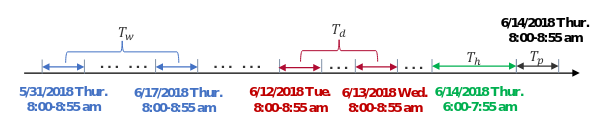

If we want to predict the traffic in the next hour e.g. (Thursday 8:00 AM) 

We can use :
## 1. The recent segment

We use the last two hours. Based on the traffic from 6:00 to 8:00 AM, we will predict the traffic of 8:00 AM

Intuition : The formation and dispersion of traffic congestions are gradual. So, the just past traffic flows inevitably have influence on the future traffic flows

## 2. The daily-periodic segment

We use the same hour in the last week and the same hour yesterday and the day before. Based on the traffic at 8:00 AM on tuesday and wednesday, we will predict the traffic of 8:00 AM on thursday.

Intuition: Due to the regular daily routine of people, traffic data may show repeated patterns, such as the daily morning peaks. The purpose of the daily-period component is to model the daily periodicity of traffic data.

## 3. The weekly-periodic segment

We use the same hour in the last week and the same hour in the week before the last week. Based on the traffic at 8:00 AM on the thursday in the past two weeks, we will predict the traffic of 8:00 AM

Intuition: Usually, the traffic patterns on Monday have a certain similarity with the traffic patterns on Mondays in history, but may be greatly different from those on weekends. Thus, the weekly-period component is designed to capture the weekly periodic features in traffic data.



### The three ways can be used to build three different models and the output prediction of the three models can be fused as the final output. 



In our example we sample data per hour, so ignore anything about weeks or days

Each hour's data is used to predict the next hour's data

the 1 hour data(INPUT) is of shape (12, 307, 3) and the next hour(TARGET) is the same  (12, 307, 3)

The functions get_sample_indices and search_data simply finds the input and the target since the orininal data have 16992 points collected every 5 minutes 


for example, 
the first 12 points(0:12) will be extracted from original data have 16992 points i.e. original[0:12]
The target is the next hour so it will  be the next 12 points(12:24) i.g. original[12:24] 

Cool ... generate more .. move 5 minutes in the future ....

the first 12 points(1:13) will be extracted from original data have 16992 points i.e. original[1:13]
The target is the next hour so it will  be the next 12 points(13:25) i.g. original[13:25] 


And sooooo on. 

How many INPUT data and TARGET examples do we have now ? 
We havee 16969 examples which is 16992 (original) - 23 

The missing 23 points are the first 11 points(first hour) in the original sequence and the last 12 points(last hour) in the sequence i.e. the first hour data can't be predicted from any other previous data and the last hour data can't be used for predicting any future data because it's the last one in the training. So we ingore both. 

## Data splitting

10181 data/target examples will be used as the training set ( 35 days )

3394 data/target examples will be used as the validation set (12 days)

3394 data/target examples will be used as the testing set (12 days)


In [2]:
def search_data(sequence_length, num_of_depend, label_start_idx,num_for_predict, units, points_per_hour):
    '''
    Parameters
    ----------
    sequence_length: int, length of all history data
    num_of_depend: int,
    label_start_idx: int, the first index of predicting target
    num_for_predict: int, the number of points will be predicted for each sample
    units: int, week: 7 * 24, day: 24, recent(hour): 1
    points_per_hour: int, number of points per hour, depends on data
    Returns
    ----------
    list[(start_idx, end_idx)]
    '''

    if points_per_hour < 0:
        raise ValueError("points_per_hour should be greater than 0!")

    if label_start_idx + num_for_predict > sequence_length:
        return None

    x_idx = []
    for i in range(1, num_of_depend + 1):
        start_idx = label_start_idx - points_per_hour * units * i
        end_idx = start_idx + num_for_predict
        if start_idx >= 0:
            x_idx.append((start_idx, end_idx))
        else:
            return None

    if len(x_idx) != num_of_depend:
        return None

    return x_idx[::-1]

In [3]:
def get_sample_indices(data_sequence, num_of_weeks, num_of_days, num_of_hours, label_start_idx, num_for_predict, points_per_hour=12):
    '''
    Parameters
    ----------
    data_sequence: np.ndarray shape is (sequence_length, num_of_vertices, num_of_features)
    num_of_weeks, num_of_days, num_of_hours: int
    label_start_idx: int, the first index of predicting target
    num_for_predict: int,the number of points will be predicted for each sample
    points_per_hour: int, default 12, number of points per hour
    Returns
    ----------
    week_sample: np.ndarray shape is (num_of_weeks * points_per_hour, num_of_vertices, num_of_features)
    day_sample: np.ndarray shape is (num_of_days * points_per_hour,  num_of_vertices, num_of_features)
    hour_sample: np.ndarray   shape is (num_of_hours * points_per_hour, num_of_vertices, num_of_features)
    target: np.ndarray shape is (num_for_predict, num_of_vertices, num_of_features)
    '''
    week_sample, day_sample, hour_sample = None, None, None
#------------------------------------Ignore
    if label_start_idx + num_for_predict > data_sequence.shape[0]: 
        return week_sample, day_sample, hour_sample, None

    if num_of_weeks > 0:
        week_indices = search_data(data_sequence.shape[0], num_of_weeks, label_start_idx, num_for_predict,7 * 24, points_per_hour)
        if not week_indices:
            return None, None, None, None

        week_sample = np.concatenate([data_sequence[i: j] for i, j in week_indices], axis=0)

    if num_of_days > 0:
        day_indices = search_data(data_sequence.shape[0], num_of_days,  label_start_idx, num_for_predict, 24, points_per_hour)
        if not day_indices:
            return None, None, None, None

        day_sample = np.concatenate([data_sequence[i: j] for i, j in day_indices], axis=0)
#----------------------------------Continue
    if num_of_hours > 0:
        hour_indices = search_data(data_sequence.shape[0], num_of_hours, label_start_idx, num_for_predict, 1, points_per_hour)
        if not hour_indices:
            return None, None, None, None
        hour_sample = np.concatenate([data_sequence[i: j] for i, j in hour_indices], axis=0)
    
    if num_of_hours > 10:
        return 1;
    target = data_sequence[label_start_idx: label_start_idx + num_for_predict]

    return week_sample, day_sample, hour_sample, target

In [4]:
def read_and_generate_dataset(graph_signal_matrix_filename, num_of_weeks, num_of_days, num_of_hours, num_for_predict, points_per_hour=12):
    '''
    Parameters
    ----------
    graph_signal_matrix_filename: str, path of graph signal matrix file
    num_of_weeks, num_of_days, num_of_hours: int
    num_for_predict: int
    points_per_hour: int, default 12, depends on data
    Returns
    ----------
    feature: np.ndarray, shape is (num_of_samples, num_of_depend * points_per_hour, num_of_vertices, num_of_features)
    target: np.ndarray, shape is (num_of_samples, num_of_vertices, num_for_predict)
    '''
    #--------------------------------- Read original data 
    data_seq = np.load(graph_signal_matrix_filename)['data']  # (sequence_length, num_of_vertices, num_of_features) (16992, 307, 3)
    
    #---------------------------------
    all_samples = []
    for idx in range(data_seq.shape[0]):
        sample = get_sample_indices(data_seq, num_of_weeks, num_of_days, num_of_hours, idx, num_for_predict, points_per_hour)
        if ((sample[0] is None) and (sample[1] is None) and (sample[2] is None)):
            continue

        week_sample, day_sample, hour_sample, target = sample #  week_sample, day_sample are None because we are predicting per hour
        #print(target.shape) # hour_sample and target (12, 307, 3)
        sample = []  # [(week_sample),(day_sample),(hour_sample),target,time_sample]
#-------------------------------- Ignore
        if num_of_weeks > 0:
            week_sample = np.expand_dims(week_sample, axis=0).transpose((0, 2, 3, 1))  # (1,N,F,T)
            sample.append(week_sample)

        if num_of_days > 0:
            day_sample = np.expand_dims(day_sample, axis=0).transpose((0, 2, 3, 1))  # (1,N,F,T)
            sample.append(day_sample)
#----------------------------------Continue
        if num_of_hours > 0:
            hour_sample = np.expand_dims(hour_sample, axis=0).transpose((0, 2, 3, 1))  # (1,N,F,T)
            sample.append(hour_sample)

        target = np.expand_dims(target, axis=0).transpose((0, 2, 3, 1))[:, :, 0, :]  # (1,N,T)
        sample.append(target)
        time_sample = np.expand_dims(np.array([idx]), axis=0)  # (1,1)
        sample.append(time_sample)
        all_samples.append(sample)#sampe：[(week_sample),(day_sample),(hour_sample),target,time_sample] = [(1,N,F,Tw),(1,N,F,Td),(1,N,F,Th),(1,N,Tpre),(1,1)]

    split_line1 = int(len(all_samples) * 0.6)
    split_line2 = int(len(all_samples) * 0.8)

    training_set = [np.concatenate(i, axis=0)  for i in zip(*all_samples[:split_line1])] #[(B,N,F,Tw),(B,N,F,Td),(B,N,F,Th),(B,N,Tpre),(B,1)]
    validation_set = [np.concatenate(i, axis=0) for i in zip(*all_samples[split_line1: split_line2])]
    testing_set = [np.concatenate(i, axis=0) for i in zip(*all_samples[split_line2:])]

    return training_set, validation_set, testing_set

In [5]:
graph_signal_matrix_filename = '../input/pems-dataset/data/PEMS04/PEMS04.npz'
data = np.load(graph_signal_matrix_filename)
data['data'].shape

(16992, 307, 3)

In [6]:
data = np.load(graph_signal_matrix_filename)
data['data'].shape

num_of_vertices = 307
points_per_hour = 12
num_for_predict = 12
num_of_weeks = 0
num_of_days = 0
num_of_hours = 1

training_set, validation_set, testing_set = read_and_generate_dataset(graph_signal_matrix_filename, 0, 0, num_of_hours, 
                                                                      num_for_predict, points_per_hour=points_per_hour)

# Data normalization

 the data are transformed by zero-mean normalization x′ = x −mean(x) to let the average be 0.

In [7]:
def normalization(train, val, test):
    '''
    Parameters
    ----------
    train, val, test: np.ndarray (B,N,F,T)
    Returns
    ----------
    stats: dict, two keys: mean and std
    train_norm, val_norm, test_norm: np.ndarray,
                                     shape is the same as original
    '''

    assert train.shape[1:] == val.shape[1:] and val.shape[1:] == test.shape[1:]  # ensure the num of nodes is the same
    mean = train.mean(axis=(0,1,3), keepdims=True)
    std = train.std(axis=(0,1,3), keepdims=True)
    print('mean.shape:',mean.shape)
    print('std.shape:',std.shape)

    def normalize(x):
        return (x - mean) / std

    train_norm = normalize(train)
    val_norm = normalize(val)
    test_norm = normalize(test)

    return {'_mean': mean, '_std': std}, train_norm, val_norm, test_norm

In [8]:
train_x = np.concatenate(training_set[:-2], axis=-1)  # (B,N,F,T')
val_x = np.concatenate(validation_set[:-2], axis=-1)
test_x = np.concatenate(testing_set[:-2], axis=-1)

train_target = training_set[-2]  # (B,N,T)
val_target = validation_set[-2]
test_target = testing_set[-2]

train_timestamp = training_set[-1]  # (B,1)
val_timestamp = validation_set[-1]
test_timestamp = testing_set[-1]

(stats, train_x_norm, val_x_norm, test_x_norm) = normalization(train_x, val_x, test_x)

all_data = {'train': { 'x': train_x_norm, 'target': train_target,'timestamp': train_timestamp},
            'val': {'x': val_x_norm, 'target': val_target, 'timestamp': val_timestamp},
            'test': {'x': test_x_norm, 'target': test_target, 'timestamp': test_timestamp},
            'stats': {'_mean': stats['_mean'], '_std': stats['_std']} }

mean.shape: (1, 1, 3, 1)
std.shape: (1, 1, 3, 1)


In [9]:
print('train x:', all_data['train']['x'].shape)
print('train target:', all_data['train']['target'].shape)
print('train timestamp:', all_data['train']['timestamp'].shape)
print()
print('val x:', all_data['val']['x'].shape)
print('val target:', all_data['val']['target'].shape)
print('val timestamp:', all_data['val']['timestamp'].shape)
print()
print('test x:', all_data['test']['x'].shape)
print('test target:', all_data['test']['target'].shape)
print('test timestamp:', all_data['test']['timestamp'].shape)
print()
print('train data _mean :', all_data['stats']['_mean'].shape, all_data['stats']['_mean'])
print('train data _std :', all_data['stats']['_std'].shape, all_data['stats']['_std'])


train x: (10181, 307, 3, 12)
train target: (10181, 307, 12)
train timestamp: (10181, 1)

val x: (3394, 307, 3, 12)
val target: (3394, 307, 12)
val timestamp: (3394, 1)

test x: (3394, 307, 3, 12)
test target: (3394, 307, 12)
test timestamp: (3394, 1)

train data _mean : (1, 1, 3, 1) [[[[2.07227338e+02]
   [5.13195612e-02]
   [6.34740574e+01]]]]
train data _std : (1, 1, 3, 1) [[[[1.56477655e+02]
   [4.78541626e-02]
   [8.10351724e+00]]]]


In [10]:
file = os.path.basename(graph_signal_matrix_filename).split('.')[0]
dirpath = '.'
filename = os.path.join(dirpath, file + '_r' + str(num_of_hours) + '_d' + str(num_of_days) + '_w' + str(num_of_weeks)) + '_astcgn'
print('save file:', filename)
np.savez_compressed(filename,
                train_x=all_data['train']['x'],train_target=all_data['train']['target'],train_timestamp=all_data['train']['timestamp'],
                val_x=all_data['val']['x'], val_target=all_data['val']['target'],val_timestamp=all_data['val']['timestamp'],
                test_x=all_data['test']['x'], test_target=all_data['test']['target'], test_timestamp=all_data['test']['timestamp'],
                mean=all_data['stats']['_mean'], std=all_data['stats']['_std'])

save file: ./PEMS04_r1_d0_w0_astcgn
